# 1. Load modules

In [1]:
%matplotlib widget 
#%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import matplotlib.ticker as ticker
from scipy import optimize
import os, sys
from pathlib import Path
import xrdpy

# 2. Set up the xrd-file path

In [2]:
xrdpy_test_path = Path().absolute()

In [3]:
filepath = os.path.join(xrdpy_test_path,"xrd_files")
filename1 = "NT3330_RSM_w2T-2T-105AlN-AlGaN.xrdml"
filename2 = "NT3334C_RSM_w2T-2T-105AlN-AlGaN_fast.xrdml"
#filename2 = 'NT3285_RSM_w-2T_105AlGaN_calibration_fine.xrdml'

In [4]:
savefig = True
save_fig_path = os.path.join(xrdpy_test_path,"../imgs")

In [5]:
gen_fns = xrdpy.general_fns(print_log='low')
xrd_ = xrdpy.xrd(print_log='low')
xrd_plt = xrdpy.plottings(save_figure_dir=save_fig_path, print_log='low')

# 3. Set default variables

#### Variable source: https://www.ioffe.ru/SVA/NSM/Semicond/

In [6]:
alloy_type='ternary' 
structure_type='wz'

# Lattice parameters for AlN and GaN binaries
AlN_a, AlN_c = 3.112, 4.982
GaN_a, GaN_c = 3.189, 5.185    

# Cij parameters for AlN and GaN binaries
GaN_C13 = 106
GaN_C33 = 398
AlN_C13 = 108
AlN_C33 = 373

# Bowing parameters
bowing_a = 0.0
bowing_c = 0.0
bowing_C13 = 0.0
bowing_C33 = 0.0

# reciprocal axes are multiplited by this number to make enlarge axes
mul_fact = [10000,10000]

# a_lp_bin: [a_lattice_parameter bin_1, a_lattice_parameter bin_2, bowing]
# For ternary_wz we need followings: [a_lp_bin, c_lp_bin, c13_bin, c33_bin]
# Alloy_params = x*list_binary_parameters[i][0] + (1-x)*list_binary_parameters[i][1]+bowing*x*1-x
# WARNING: Maintain the order of data given for material parameters for all list below. 
# E.g. Do not do like [[AlN_data, GaN_data, bowing],[GaN_data, AlN_data, bowing],...]
list_binary_parameters = [[AlN_a, GaN_a, bowing_a], [AlN_c, GaN_c, bowing_c],
                          [AlN_C13, GaN_C13, bowing_C13], [AlN_C33, GaN_C33, bowing_C33]]

# Reflection plane hkl
hkl = (1,0,5)

# 4. Read xrd-file

## 4.1 Real space data

In [7]:
lambda_wavelength1, two_theta_values1, omega_values1, rsm_intesity1  = \
    xrd_.xrd_read_data(xrd_file_name=os.path.join(filepath, filename1))
#==========================================================================================
lambda_wavelength2, two_theta_values2, omega_values2, rsm_intesity2  = \
    xrd_.xrd_read_data(xrd_file_name=os.path.join(filepath, filename2))
#==========================================================================================
# X-ray wave number
R1 = 1/lambda_wavelength1
R2 = 1/lambda_wavelength2

Wavelength used (from xrd file): 1.5405980
Intensity unit (from xrd file): counts/seconds
Wavelength used (from xrd file): 1.5405980
Intensity unit (from xrd file): counts/seconds


## 4.2 Reciprocal space conversion

In [8]:
total_two_theta_in_row1 = np.shape(rsm_intesity1)[1]
rec_space_x1, rec_space_y1 = xrd_.Qxy(omega=omega_values1, two_theta=two_theta_values1,
                                      total_two_theta_in_row=total_two_theta_in_row1,
                                      R=R1, mul_fact=mul_fact)
#==========================================================================================
total_two_theta_in_row2 = np.shape(rsm_intesity2)[1]
rec_space_x2, rec_space_y2 = xrd_.Qxy(omega=omega_values2, two_theta=two_theta_values2,
                                      total_two_theta_in_row=total_two_theta_in_row2,
                                      R=R2, mul_fact=mul_fact)

# 5. Merge two plots

## 5.1 Plot them just side by side

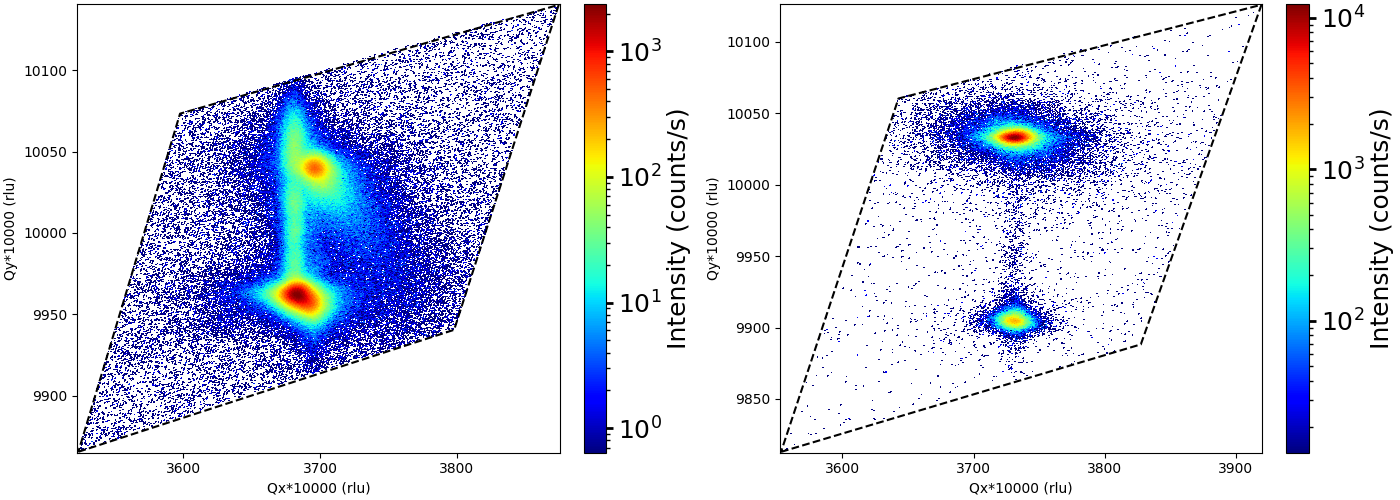

In [9]:
xlabel_text = f'Qx*{mul_fact[0]} (rlu)'
ylabel_text = f'Qy*{mul_fact[1]} (rlu)'
save_file_name = None

fig, axs = plt.subplots(1, 2, figsize=(14,5), constrained_layout=True)
#====================== Plot the map =================================
fig, _, _ = xrd_plt.xrd_plot(fig=fig, ax=axs[0], show_plot=False,
                              save_file_name=None, x_values=rec_space_x1, 
                              y_values=rec_space_y1, z_values=rsm_intesity1,
                              mode="reciprocal_space", xaxis_label=xlabel_text,
                              yaxis_label=ylabel_text, color_map='jet', color_scale='log',
                              colorbar_label='Intensity (counts/s)')
#====================== Plot the map =================================
fig, _, _ = xrd_plt.xrd_plot(fig=fig, ax=axs[1], 
                              save_file_name=None, x_values=rec_space_x2, 
                              y_values=rec_space_y2, z_values=rsm_intesity2,
                              mode="reciprocal_space", xaxis_label=xlabel_text,
                              yaxis_label=ylabel_text, color_map='jet', color_scale='log',
                              colorbar_label='Intensity (counts/s)')

## 5.2 Plot them just side by side but remove 2nd y-axis

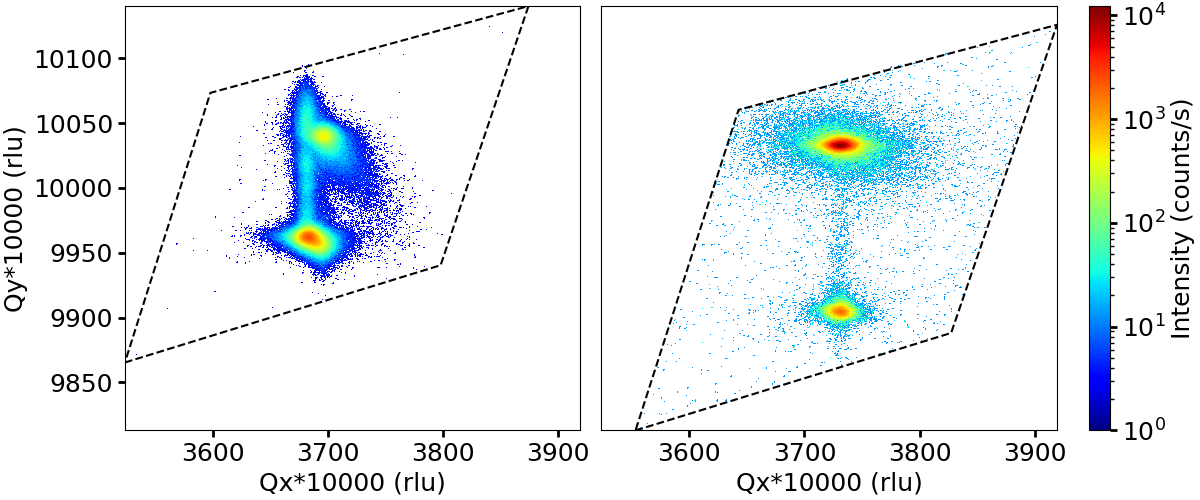

In [10]:
xlabel_text = f'Qx*{mul_fact[0]} (rlu)'
ylabel_text = f'Qy*{mul_fact[1]} (rlu)'

vmin, vmax = 1, max(rsm_intesity1.max(), rsm_intesity2.max()) # vmin can not be exatly 0.
threshold_intensity_ = 2

xmin, xmax = min(rec_space_x1.min(), rec_space_x2.min()), max(rec_space_x1.max(), rec_space_x2.max())
ymin, ymax = min(rec_space_y1.min(), rec_space_y2.min()), max(rec_space_y1.max(), rec_space_y2.max())

fig, axs = plt.subplots(1, 2, figsize=(12,5), constrained_layout=True)

#====================== Plot the map =================================
fig, _, _ = xrd_plt.xrd_plot(fig=fig, ax=axs[0], show_plot=False,
                             Ymin=ymin, Ymax=ymax, Xmin=xmin, Xmax=xmax,
                              save_file_name=None, x_values=rec_space_x1, 
                              y_values=rec_space_y1, z_values=rsm_intesity1,
                              mode="reciprocal_space", xaxis_label=xlabel_text,
                             vmin=vmin, vmax=vmax, threshold_intensity=threshold_intensity_,
                              yaxis_label=ylabel_text, color_map='jet', color_scale='log',
                              colorbar_label='Intensity (counts/s)', show_colorbar=False)
axs[1].yaxis.set_visible(False)

#******************************************************************************************************
#====================== Plot the map =================================
fig, _, _ = xrd_plt.xrd_plot(fig=fig, ax=axs[1], Ymin=ymin, Ymax=ymax,
                             Xmin=xmin, Xmax=xmax, vmin=vmin, vmax=vmax,
                             x_values=rec_space_x2, show_plot=False,
                             y_values=rec_space_y2, z_values=rsm_intesity2,
                             mode="reciprocal_space", xaxis_label=xlabel_text,
                             threshold_intensity=threshold_intensity_,
                             yaxis_label='', color_map='jet', color_scale='log',
                             colorbar_label='Intensity (counts/s)')

## 5.3 Plot them in same plot
Note: in this case x-axis would be longer

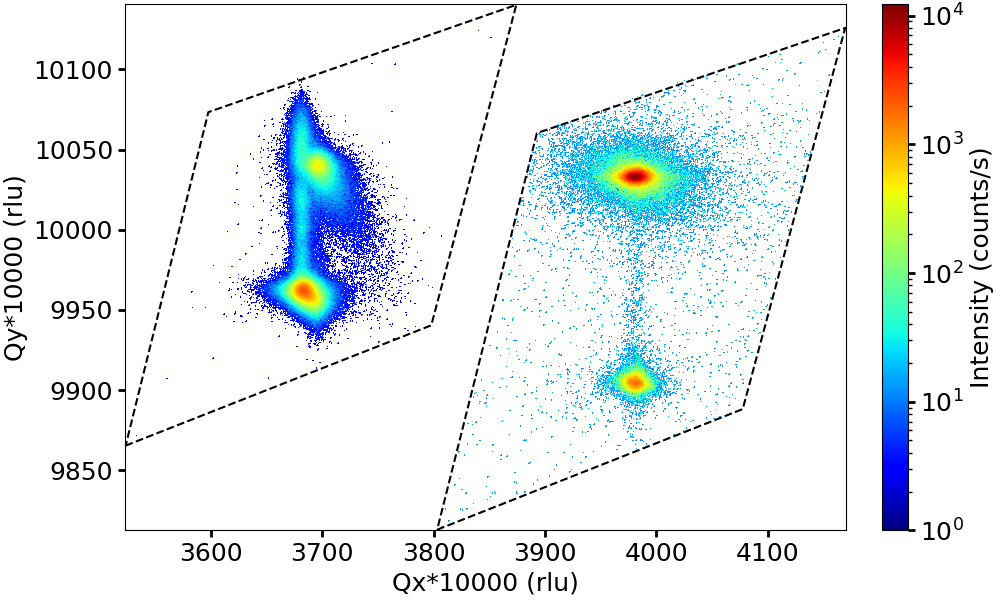

In [11]:
xlabel_text = f'Qx*{mul_fact[0]} (rlu)'
ylabel_text = f'Qy*{mul_fact[1]} (rlu)'

vmin, vmax = 1, max(rsm_intesity1.max(), rsm_intesity2.max()) # vmin can not be exatly 0.
threshold_intensity_ = 2
shift_2nd_plot = 250
#xmin, xmax = rec_space_x1.min(), rec_space_x_shift2.min()), max(rec_space_x_shift1.max(), rec_space_x_shift2.max())
#ymin, ymax = min(rec_space_y_shift1.min(), rec_space_y_shift2.min()), max(rec_space_y_shift1.max(), rec_space_y_shift2.max())

fig1, ax1 = plt.subplots(1, 1, figsize=(10,6), constrained_layout=True)

fig1, ax1, _ = xrd_plt.xrd_plot(fig=fig1, ax=ax1, save_file_name=None, x_values=rec_space_x1,
                                y_values=rec_space_y1, z_values=rsm_intesity1,
                                mode="reciprocal_space", xaxis_label=xlabel_text, 
                                yaxis_label=ylabel_text, vmin=vmin, vmax=vmax,
                                color_map='jet', show_plot=False, threshold_intensity=threshold_intensity_,
                                color_scale='log', show_colorbar=False)
fig1, ax1, _ = xrd_plt.xrd_plot(fig=fig1, ax=ax1, threshold_intensity=threshold_intensity_,
                                save_file_name=None, x_values=rec_space_x2+shift_2nd_plot,
                                y_values=rec_space_y2, z_values=rsm_intesity2,
                                vmin=vmin, vmax=vmax, mode="reciprocal_space", 
                                xaxis_label=xlabel_text, yaxis_label=ylabel_text, 
                                color_map='jet', color_scale='log',show_plot=False,
                                colorbar_label='Intensity (counts/s)')
